# Relative motion estimation between 2 frames

## 1. Import libraries vs. images

In [1]:
import matplotlib.pyplot as plt
from utils import *
from contours_extraction import *
from tracking import *
import cv2
import json
import numpy as np

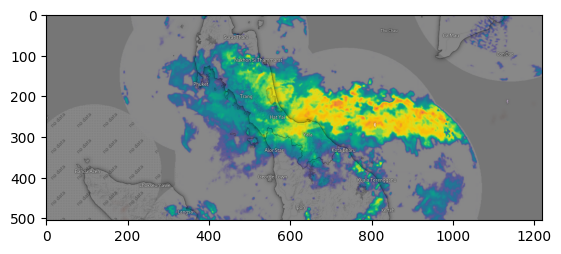

In [2]:
img_paths = [
    'data/image_old/malaysia_20241128-050508.png',
    'data/image_old/malaysia_20241128-052509.png',
    'data/image_old/malaysia_20241128-054509.png',
    'data/image_old/malaysia_20241128-060509.png',
    'data/image_old/malaysia_20241128-062510.png',
    'data/image_old/malaysia_20241128-065657.png',
    'data/image_old/malaysia_20241128-071658.png',
]
color_path = 'data/legend/color_dbz.json'

with open('data/legend/color_dbz.json') as f:
    list_color = json.load(f)

sorted_color = sorted({tuple(color[1]): color[0] for color in list_color}.items(), key=lambda item: item[1])

src_images = [read_image(path) for path in img_paths]
plt.imshow(src_images[0])
plt.show()

## 2. Identification

- Extract the contours

- Simplify the contours using Douglas-Peucker algorithm

- Extract point descriptors

### 2.1 Extract the contours

| Variable | Description |
| --- | --- |
| *contours_time* | a list of *contours_dbz* set in vary of time. |
| *contours_dbz* | a list of *contours* set in vary of DBz. |
| *contours* | a list of *contour* of a dbz in a specific time. |
| *contour* | a list of *points* which is of shape (1, 2). |

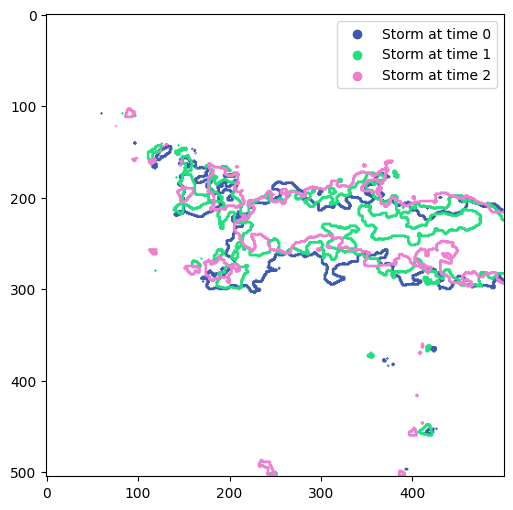

In [3]:
contours_time = [extract_contour_by_dbz(img, thresholds=[35], sorted_color=sorted_color)[1] for img in src_images]
num_of_contours = len(contours_time)

# Plot contours
plt.figure(figsize=(6, 6))

blank_img = np.ones_like(src_images[0], dtype=np.uint8) * 255
np.random.seed(2025)
color_set = np.random.randint(0, 256, size=(num_of_contours, 3), dtype=np.uint8)

for i, (contours_dbz, color) in enumerate(zip(contours_time, color_set)):
    color = tuple(int(c) for c in color)
    scaled_color = tuple(c / 255.0 for c in color)

    cv2.drawContours(blank_img, contours=contours_dbz[0], contourIdx=-1, thickness=2, color=color)
    plt.scatter([], [], c=[scaled_color], label=f"Storm at time {i}")
    if i >= 2:
        break

plt.imshow(blank_img[:, 400:900])
plt.legend()
plt.show()

### 2.2 Simplify contours

Number of polygons in time 1 before simplifying: 35
Number of polygons in time 1 after simplifying: 17


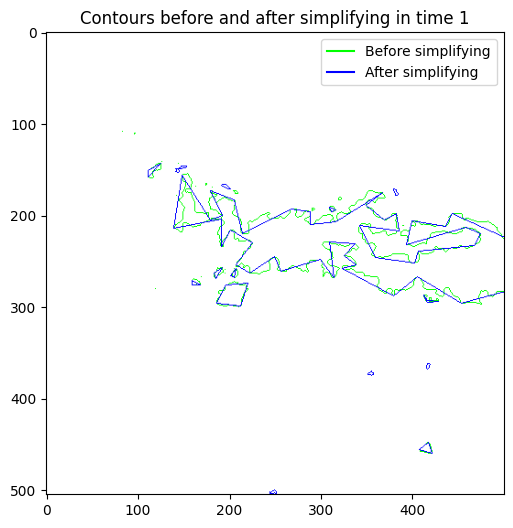

In [17]:
polygons_time = [process_contours(contours_dbz[0]) for contours_dbz in contours_time]

plt.figure(figsize=(6, 6))
# plt.subplot(1, 2, 1)
idx = 1
contours = contours_time[idx][0]
simplified_contours = polygons_to_contours(polygons_time[idx])

print(f"Number of polygons in time {idx} before simplifying: {len(contours)}")
print(f"Number of polygons in time {idx} after simplifying: {len(simplified_contours)}")


blank_img = np.ones_like(src_images[0], dtype=np.uint8) * 255
cv2.drawContours(blank_img, contours, -1, color=(0, 255, 0), thickness=1)
cv2.drawContours(blank_img, simplified_contours, -1, color=(0, 0, 255), thickness=1)

plt.plot([], [], color=(0, 1, 0), label="Before simplifying")
plt.plot([], [], color=(0, 0, 1), label="After simplifying")

plt.title(f"Contours before and after simplifying in time {idx}")
plt.imshow(blank_img[:, 400:900])
plt.legend()
plt.show()

### 2.3 Extract vector shape features

In [5]:
point_features = []
radii = [20, 60, 100, 200]
num_sectors = 8

shape_vectors_time = []

for idx, polygons in enumerate(polygons_time):
    shape_vectors = []
    for polygon in polygons:
        shape_vectors.append([    # since point has shape (1, 2)
            ShapeVector(point, construct_shape_vector(polygons, point, radii, num_sectors)) \
            for point in list(polygon.exterior.coords)
        ])

    shape_vectors_time.append(shape_vectors)

### An illustration for the shape vector

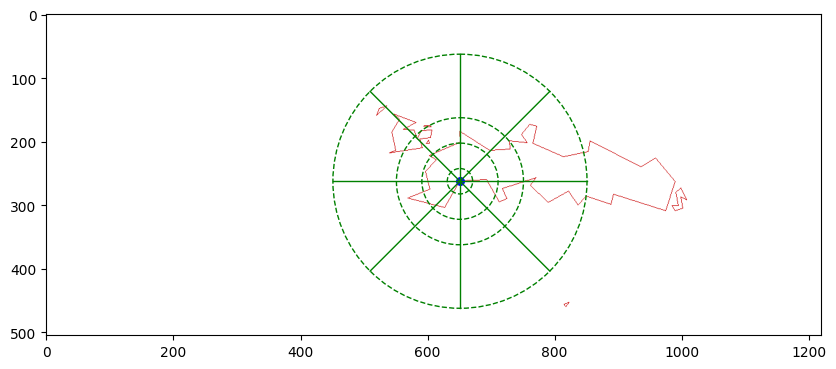

In [6]:
time = 0
pol_idx = 0
vertex_idx = 2

shape_vector = shape_vectors_time[time][pol_idx][vertex_idx]
point = shape_vector.coord
vector = shape_vector.vector
contours = polygons_to_contours(polygons_time[time])

def plot_shape_vector(contours, point_A, radii, num_sectors):
    plt.figure(figsize=(10, 10))
    fig = plt.gcf()
    ax = fig.gca()

    blank_img = np.ones_like(src_images[0], dtype=np.int16) * 255

    # Plot polygon (assuming you have a helper function plot_contour)
    cv2.drawContours(blank_img, contours, -1, color=(200,0,0), thickness=1)

    # Add circles
    for r in radii:
        circle = plt.Circle(point_A, radius=r, color='green', fill=False, linestyle="--")
        ax.add_patch(circle)

    # Add radial lines (sectors)
    longest_r = max(radii)
    for i in range(num_sectors):
        grad_angle = np.deg2rad(i * (360 / num_sectors))
        x_start, y_start = point_A
        x_end = x_start + np.cos(grad_angle) * longest_r
        y_end = y_start + np.sin(grad_angle) * longest_r
        plt.plot([x_start, x_end], [y_start, y_end], color="green", linewidth=1)

    # Mark the reference point
    plt.scatter([point_A[0]], [point_A[1]], marker='o', s=30, color="blue", label="Point A")

    plt.imshow(blank_img)
    plt.show()

plot_shape_vector(contours, point, radii, num_sectors)

## 3. Model Tracking

### 3.1 Estimate the movement

In [7]:
r = radii[-1]
circle_area = r * r * np.pi

prev = 1
curr = 2

shape_vectors_prev = shape_vectors_time[prev]
shape_vectors_curr = shape_vectors_time[curr]

displacement_lists = []

for i, pol_1 in enumerate(shape_vectors_prev):
    best_score = float("inf")
    best_move = None

    for j, pol_2 in enumerate(shape_vectors_curr):
        score, move = compute_movement(pol_1, pol_2, circle_area, threshold=0.08)
        if score < best_score:
            best_score = score
            best_move = move
    
    displacement_lists.append((best_score, best_move))

for idx, item in enumerate(displacement_lists, start=1):
    score, (dx, dy) = item
    print(f"{idx}.")
    print(f"Score: {score}")
    print(f"Move: ({dx:.2f}, {dy:.2f})")

1.
Score: 0.016866056183780762
Move: (-4.99, -9.23)
2.
Score: 0.02740058487500093
Move: (-14.09, -7.83)
3.
Score: 0.005636297980886223
Move: (-11.76, 1.05)
4.
Score: 0.011572481443383246
Move: (-2.03, 11.28)
5.
Score: 0.03754736940916398
Move: (6.56, 12.43)
6.
Score: 0.020897971578366214
Move: (-29.69, 10.73)
7.
Score: 0.03236671956072697
Move: (-78.75, -8.42)
8.
Score: 0.022507613598466918
Move: (-3.05, 4.91)
9.
Score: 0.04618508153794174
Move: (23.34, -14.36)
10.
Score: 0.017315258078885915
Move: (-42.98, 1.01)
11.
Score: 0.028007901479774368
Move: (-8.37, -12.54)
12.
Score: 0.001297112786198948
Move: (-9.32, -9.93)
13.
Score: 0.041616496888040165
Move: (2.67, -14.00)
14.
Score: 0.11422053004864006
Move: (0.00, 0.00)
15.
Score: 0.12358593727362815
Move: (0.00, 0.00)
16.
Score: 0.05083287049079454
Move: (41.16, -4.99)
17.
Score: 0.020700229714791716
Move: (-60.00, -7.38)


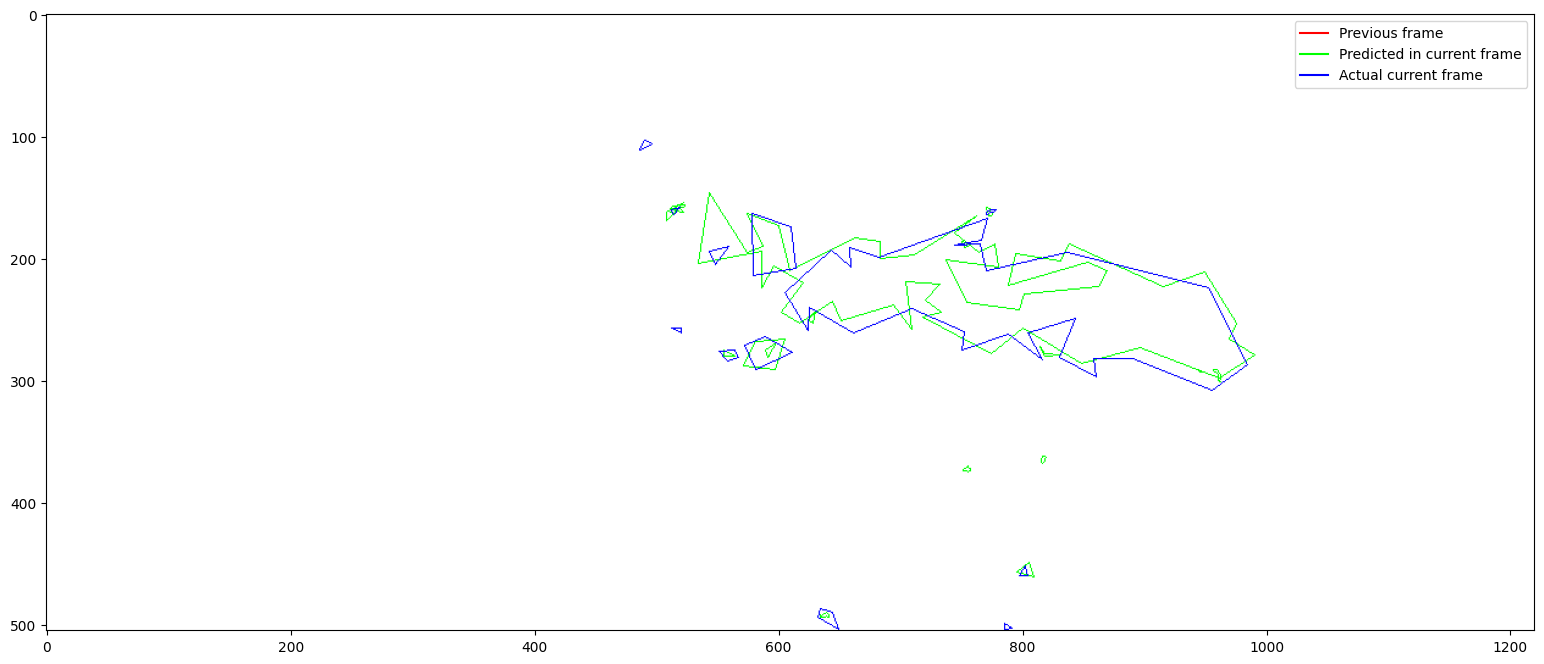

In [13]:
from shapely.affinity import translate

predicted_polygons = []
prev_polygons = polygons_time[prev]
actual_polygons = polygons_time[curr]

for polygon, (_, (dx, dy)) in zip(prev_polygons, displacement_lists):
    predicted_polygons.append(translate(polygon, xoff=dx, yoff=dy))

# prev_contours = polygons_to_contours(prev_polygons)
predicted_contours = polygons_to_contours(predicted_polygons)
actual_contours = polygons_to_contours(actual_polygons)

plt.figure(figsize=(20, 8))
blank_img = np.ones_like(src_images[0], dtype=np.uint8) * 255

# cv2.drawContours(blank_img, prev_contours, -1, color=(255, 0, 0), thickness=1)
cv2.drawContours(blank_img, predicted_contours, -1, color=(0, 255, 0), thickness=1)
cv2.drawContours(blank_img, actual_contours, -1, color=(0, 0, 255), thickness=1)
plt.plot([], [], color=(1, 0, 0), label=f"Previous frame")
plt.plot([], [], color=(0, 1, 0), label=f"Predicted in current frame")
plt.plot([], [], color=(0, 0, 1), label=f"Actual current frame")

plt.imshow(blank_img)
plt.legend()
plt.show()

In [14]:
overlapping_matrix_pred = compute_overlapping(predicted_polygons, actual_polygons)
overlapping_matrix_origin = compute_overlapping(prev_polygons, actual_polygons)

overlapping_pred = overlapping_matrix_pred.sum(axis=-1)
overlapping_origin = overlapping_matrix_origin.sum(axis=-1)

areas = [pol.area for pol in predicted_polygons]
total_area = sum(areas)

overlapping_ratio_pred = sum([ratio * area / total_area for ratio, area in zip(overlapping_pred, areas)])
overlapping_ratio_origin = sum([ratio * area / total_area for ratio, area in zip(overlapping_origin, areas)])

overlapping_ratio_pred

np.float32(0.8301944)

In [10]:
# plt.figure(figsize=(20, 12))
# blank_img = np.ones_like(src_images[0], dtype=np.uint8) * 255

# i, j = 0, 0

# cv2.drawContours(blank_img, [predicted_contours[i]], -1, color=(0, 255, 0), thickness=1)
# cv2.drawContours(blank_img, [actual_contours[j]], -1, color=(0, 0, 255), thickness=1)
# plt.plot([], [], color=(0, 1, 0), label=f"Predicted in current frame")
# plt.plot([], [], color=(0, 0, 1), label=f"Actual current frame")

# overlapping_matrix_pred = compute_overlapping([predicted_polygons[i]], [actual_polygons[j]])
# overlapping_matrix_last = compute_overlapping([prev_polygons[j]], [actual_polygons[i]])
# print(f"overlapping_matrix_pred = {overlapping_matrix_pred}")
# print(f"overlapping_matrix_last = {overlapping_matrix_last}")

# plt.imshow(blank_img[:, 400:1200])
# plt.legend()
# plt.show()